## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [37]:
# Install libraries the first time
# !pip install -q ipynb yfinance pandas pathlib numpy

### Importing Required Libraries

In [38]:
from fastai.tabular.all import *
from fastai.tabular.all import TabularPandas
import yfinance as yf
import pandas as pd
import pathlib
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from fastai.metrics import rmse, mae
import os

### Global Variables

In [39]:
# Model settings
modelName = 'stockScreenerV8.3'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = 'NVO'  # 'ALL' for all tickers, 'None' for no prediction

# Training parameters
trainingSize = 100  # Number of stocks to use for training
timeFrame = 'max'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
catNames = ['Date']
contNames = ['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'EV/EBIT', 'ROIC']
epochs = 75

# Testing parameters
testSize = 200  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Remove Duplicate Tickers

In [40]:
df = pd.read_csv(testFolder / 'tickers.csv')
df.drop_duplicates().to_csv(testFolder / 'tickers.csv', index=False)

#### Utility Functions

In [41]:
def getIndustry(tickerSymbol):
    """Fetches the industry of the given ticker symbol."""
    try:
        return yf.Ticker(tickerSymbol).info.get('industry', 'Unknown')
    except Exception as e:
        return 'Error'

In [42]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    valid_periods = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
    try:
        if timeframe == 'max':
            future_change = yf.Ticker(ticker_symbol).history(period='max')
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)
            future_change = future_change.dropna(subset=['Future Year Change'])
        else:
            # Calculate the extended timeframe
            extended_timeframe = valid_periods[min(valid_periods.index(timeframe) + buffer, len(valid_periods) - 1)]
            future_change = yf.Ticker(ticker_symbol).history(period=extended_timeframe)
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)

            # Calculate the end date and start date based on the timeframe
            end_date = future_change.index[-1] - pd.DateOffset(years=1)
            start_date = end_date - pd.DateOffset(years=int(timeframe[:-1]))
            future_change = future_change.loc[start_date:end_date].dropna(subset=['Future Year Change'])
        return future_change
    except Exception as e:
        return pd.DataFrame()

In [43]:
def getEVComponents(tickerSymbol):
    """Fetches static EV components (total debt, cash, shares outstanding)."""
    try:
        info = yf.Ticker(tickerSymbol).info
        return info.get('totalDebt', 0), info.get('totalCash', 0), info.get('sharesOutstanding', None)
    except Exception as e:
        return None, None, None

In [44]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [45]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    for ticker in histData['Ticker'].unique():
        try:
            totalDebt, cash, sharesOutstanding = getEVComponents(ticker)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [46]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [47]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception as e:

        return pd.DataFrame()

#### Download and Process Historical Data

In [48]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()

    for ticker in trainingTickers:
        try:
            data = calculateFutureYearChange(ticker, timeFrame)
            data['Ticker'] = ticker
            data['Industry'] = getIndustry(ticker)
            histData = pd.concat([histData, data])
        except Exception:
            pass

    histData.reset_index(inplace=True)
    histData = enrichDataWithMetrics(histData)
    histData.to_csv(dataFolder / trainingData, index=False)
    print(f"Training data saved: {len(histData)} rows")

$ANDA: possibly delisted; no timezone found
C:\Users\Gamer\AppData\Local\Temp\ipykernel_11984\223849276.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  histData = pd.concat([histData, data])
$BNCN: possibly delisted; no price data found  (1d 1926-02-19 -> 2025-01-25)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_11984\223849276.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  histData = pd.concat([histData, data])
$SGNT: possibly delisted; no price data found  (1d 1926-02-19 -> 2025-01-25)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_11984\22384927

Training data saved: 420009 rows


### Model Training

In [50]:
TRAINING_CUTOFF = pd.to_datetime('2023-01-01').tz_localize('America/New_York')

df = pd.read_csv(dataFolder / trainingData)
dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

# Step 1: Convert 'Date' to datetime
dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce')  # Fix here

# Step 2: Drop rows with invalid dates
dfCleaned = dfCleaned.dropna(subset=['Date'])

# Step 4: Clean EV/EBIT
dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
dfCleaned.to_csv(dataFolder / trainingData, index=False)

# Ensure dfCleaned is not empty
if dfCleaned.empty:
    raise ValueError("The cleaned DataFrame is empty. Please check the data preprocessing steps.")

# Time-based splits
train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
valid_mask = ~train_mask
splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

# Ensure splits are not empty
if not splits[0] or not splits[1]:
    raise ValueError("The training or validation split is empty. Please check the date range and data availability.")

# TabularPandas with time-aware procs
to = TabularPandas(
    dfCleaned, procs=[Categorify, FillMissing, Normalize],
    y_names='Future Year Change',
    cat_names=['Industry'], 
    cont_names=['Open', 'Close', 'EV/EBIT', 'ROIC'],
    splits=splits
)

dls = to.dataloaders(bs=256)

C:\Users\Gamer\AppData\Local\Temp\ipykernel_11984\407577592.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce')  # Fix here


c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kw

epoch,train_loss,valid_loss,_rmse,mae,time


Model training complete


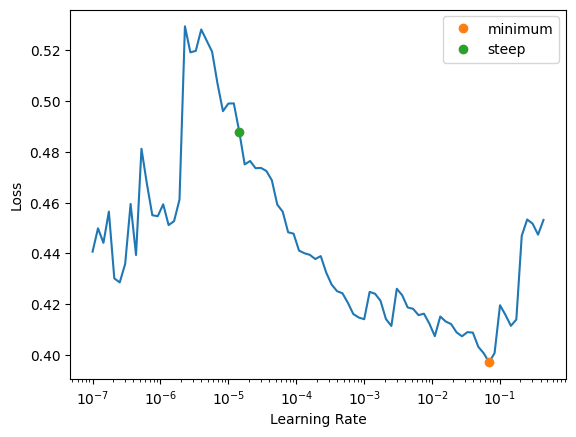

In [51]:
from fastai.tabular.all import tabular_learner

if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Train
    learn.fit_one_cycle(epochs, lr_max=3e-3)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$OMN: possibly delisted; no timezone found
$EXA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OMN: No historical data available for OMN around 2024-01-26.
Error fetching data for EXA: No historical data available for EXA around 2024-01-26.


$IRR: possibly delisted; no timezone found


Error fetching data for IRR: No historical data available for IRR around 2024-01-26.


$HEP: possibly delisted; no timezone found


Error fetching data for HEP: No historical data available for HEP around 2024-01-26.


$CHLN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CHLN: No historical data available for CHLN around 2024-01-26.


$APL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for APL: No historical data available for APL around 2024-01-26.


$DST: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$SCL.P: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DST: No historical data available for DST around 2024-01-26.
Error fetching data for SCL.P: No historical data available for SCL.P around 2024-01-26.


ISP: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


Error fetching data for ISP: single positional indexer is out-of-bounds


$BML-H: possibly delisted; no timezone found
$BEAV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BML-H: No historical data available for BML-H around 2024-01-26.
Error fetching data for BEAV: No historical data available for BEAV around 2024-01-26.


$TRR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TRR: No historical data available for TRR around 2024-01-26.


$JW.A: possibly delisted; no timezone found


Error fetching data for JW.A: No historical data available for JW.A around 2024-01-26.


$VTNR: possibly delisted; no timezone found
$OBAF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for VTNR: No historical data available for VTNR around 2024-01-26.
Error fetching data for OBAF: No historical data available for OBAF around 2024-01-26.


$AMSWA: possibly delisted; no timezone found
$BANCP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$JPZ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AMSWA: No historical data available for AMSWA around 2024-01-26.
Error fetching data for BANCP: No historical data available for BANCP around 2024-01-26.
Error fetching data for JPZ: No historical data available for JPZ around 2024-01-26.


$LHO-G: possibly delisted; no timezone found


Error fetching data for LHO-G: No historical data available for LHO-G around 2024-01-26.


$FHN-A: possibly delisted; no timezone found


Error fetching data for FHN-A: No historical data available for FHN-A around 2024-01-26.


$DCUA: possibly delisted; no timezone found


Error fetching data for DCUA: No historical data available for DCUA around 2024-01-26.


$APC: possibly delisted; no timezone found


Error fetching data for APC: No historical data available for APC around 2024-01-26.


$TCB.W: possibly delisted; no timezone found


Error fetching data for TCB.W: No historical data available for TCB.W around 2024-01-26.


$AINV: possibly delisted; no timezone found


Error fetching data for AINV: No historical data available for AINV around 2024-01-26.


$GPE-A: possibly delisted; no timezone found


Error fetching data for GPE-A: No historical data available for GPE-A around 2024-01-26.


$TYPE: possibly delisted; no timezone found
$NRCIB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$KBALB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TYPE: No historical data available for TYPE around 2024-01-26.
Error fetching data for NRCIB: No historical data available for NRCIB around 2024-01-26.
Error fetching data for KBALB: No historical data available for KBALB around 2024-01-26.


$DNR: possibly delisted; no timezone found
$SVNT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DNR: No historical data available for DNR around 2024-01-26.
Error fetching data for SVNT: No historical data available for SVNT around 2024-01-26.


$MBT: possibly delisted; no timezone found
$MSO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MBT: No historical data available for MBT around 2024-01-26.
Error fetching data for MSO: No historical data available for MSO around 2024-01-26.


$CNSI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$YOD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CNSI: No historical data available for CNSI around 2024-01-26.
Error fetching data for YOD: No historical data available for YOD around 2024-01-26.


$THST: possibly delisted; no timezone found
$NNP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$GLF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for THST: No historical data available for THST around 2024-01-26.
Error fetching data for NNP: No historical data available for NNP around 2024-01-26.
Error fetching data for GLF: No historical data available for GLF around 2024-01-26.


$FST: possibly delisted; no timezone found
$FSCI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$STSI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FST: No historical data available for FST around 2024-01-26.
Error fetching data for FSCI: No historical data available for FSCI around 2024-01-26.
Error fetching data for STSI: No historical data available for STSI around 2024-01-26.


$RKUS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RKUS: No historical data available for RKUS around 2024-01-26.


$DAEG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$SFG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DAEG: No historical data available for DAEG around 2024-01-26.
Error fetching data for SFG: No historical data available for SFG around 2024-01-26.


$NIQ: possibly delisted; no timezone found


Error fetching data for NIQ: No historical data available for NIQ around 2024-01-26.


$NNC-G: possibly delisted; no timezone found


Error fetching data for NNC-G: No historical data available for NNC-G around 2024-01-26.


$SAN-B: possibly delisted; no timezone found


Error fetching data for SAN-B: No historical data available for SAN-B around 2024-01-26.


$ECTY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$MJI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ECTY: No historical data available for ECTY around 2024-01-26.
Error fetching data for MJI: No historical data available for MJI around 2024-01-26.


$ISM: possibly delisted; no timezone found
$OCRX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$PATR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ISM: No historical data available for ISM around 2024-01-26.
Error fetching data for OCRX: No historical data available for OCRX around 2024-01-26.
Error fetching data for PATR: No historical data available for PATR around 2024-01-26.


$MILL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$JNS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MILL: No historical data available for MILL around 2024-01-26.
Error fetching data for JNS: No historical data available for JNS around 2024-01-26.


$TXTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TXTR: No historical data available for TXTR around 2024-01-26.


$HTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HTR: No historical data available for HTR around 2024-01-26.


$AKP: possibly delisted; no timezone found


Error fetching data for AKP: No historical data available for AKP around 2024-01-26.


$MNGA: possibly delisted; no timezone found
$XAA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MNGA: No historical data available for MNGA around 2024-01-26.
Error fetching data for XAA: No historical data available for XAA around 2024-01-26.


$PF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PF: No historical data available for PF around 2024-01-26.


$HBA-H: possibly delisted; no timezone found
$TNGO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$ABCD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HBA-H: No historical data available for HBA-H around 2024-01-26.
Error fetching data for TNGO: No historical data available for TNGO around 2024-01-26.
Error fetching data for ABCD: No historical data available for ABCD around 2024-01-26.


$BGSCU: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$DRAM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BGSCU: No historical data available for BGSCU around 2024-01-26.
Error fetching data for DRAM: No historical data available for DRAM around 2024-01-26.


$PPL-W: possibly delisted; no timezone found


Error fetching data for PPL-W: No historical data available for PPL-W around 2024-01-26.


$CNDO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CNDO: No historical data available for CNDO around 2024-01-26.


$AFOP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$SPLS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AFOP: No historical data available for AFOP around 2024-01-26.
Error fetching data for SPLS: No historical data available for SPLS around 2024-01-26.


$NRF-A: possibly delisted; no timezone found


Error fetching data for NRF-A: No historical data available for NRF-A around 2024-01-26.


$C-S: possibly delisted; no timezone found


Error fetching data for C-S: No historical data available for C-S around 2024-01-26.


$UIHC: possibly delisted; no timezone found


Error fetching data for UIHC: No historical data available for UIHC around 2024-01-26.


$SREV: possibly delisted; no timezone found
$KND: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SREV: No historical data available for SREV around 2024-01-26.
Error fetching data for KND: No historical data available for KND around 2024-01-26.


$DFT-A: possibly delisted; no timezone found


Error fetching data for DFT-A: No historical data available for DFT-A around 2024-01-26.


$XOXO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for XOXO: No historical data available for XOXO around 2024-01-26.


$SCR: possibly delisted; no timezone found
$PAGG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SCR: No historical data available for SCR around 2024-01-26.
Error fetching data for PAGG: No historical data available for PAGG around 2024-01-26.


$SCON: possibly delisted; no timezone found


Error fetching data for SCON: No historical data available for SCON around 2024-01-26.


$DDR-J: possibly delisted; no timezone found
$NAVR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DDR-J: No historical data available for DDR-J around 2024-01-26.
Error fetching data for NAVR: No historical data available for NAVR around 2024-01-26.


$ERS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$NYLD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ERS: No historical data available for ERS around 2024-01-26.
Error fetching data for NYLD: No historical data available for NYLD around 2024-01-26.


$HLS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HLS: No historical data available for HLS around 2024-01-26.


$VLYWW: possibly delisted; no timezone found


Error fetching data for VLYWW: No historical data available for VLYWW around 2024-01-26.


$ANH-B: possibly delisted; no timezone found


Error fetching data for ANH-B: No historical data available for ANH-B around 2024-01-26.


$CRD.A: possibly delisted; no timezone found
$NTT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$OMX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CRD.A: No historical data available for CRD.A around 2024-01-26.
Error fetching data for NTT: No historical data available for NTT around 2024-01-26.
Error fetching data for OMX: No historical data available for OMX around 2024-01-26.


$NID: possibly delisted; no timezone found


Error fetching data for NID: No historical data available for NID around 2024-01-26.


$CBX: possibly delisted; no timezone found
$BDBD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CBX: No historical data available for CBX around 2024-01-26.
Error fetching data for BDBD: No historical data available for BDBD around 2024-01-26.


$FDI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FDI: No historical data available for FDI around 2024-01-26.


$AEV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AEV: No historical data available for AEV around 2024-01-26.


$GPX: possibly delisted; no timezone found


Error fetching data for GPX: No historical data available for GPX around 2024-01-26.


$AOL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AOL: No historical data available for AOL around 2024-01-26.


$ZB-A: possibly delisted; no timezone found


Error fetching data for ZB-A: No historical data available for ZB-A around 2024-01-26.


$BKW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BKW: No historical data available for BKW around 2024-01-26.


$PRE-F: possibly delisted; no timezone found


Error fetching data for PRE-F: No historical data available for PRE-F around 2024-01-26.


$ARDNA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ARDNA: No historical data available for ARDNA around 2024-01-26.


$ROICU: possibly delisted; no timezone found


Error fetching data for ROICU: No historical data available for ROICU around 2024-01-26.


$TOO-A: possibly delisted; no timezone found
$UCP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TOO-A: No historical data available for TOO-A around 2024-01-26.
Error fetching data for UCP: No historical data available for UCP around 2024-01-26.


$HOTRW: possibly delisted; no timezone found


Error fetching data for HOTRW: No historical data available for HOTRW around 2024-01-26.


$CISG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CISG: No historical data available for CISG around 2024-01-26.


$NNC-D: possibly delisted; no timezone found


Error fetching data for NNC-D: No historical data available for NNC-D around 2024-01-26.


$NTX-C: possibly delisted; no timezone found
$LNKD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NTX-C: No historical data available for NTX-C around 2024-01-26.
Error fetching data for LNKD: No historical data available for LNKD around 2024-01-26.


$KWN: possibly delisted; no timezone found


Error fetching data for KWN: No historical data available for KWN around 2024-01-26.


$CHDX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CHDX: No historical data available for CHDX around 2024-01-26.


$UMPQ: possibly delisted; no timezone found


Error fetching data for UMPQ: No historical data available for UMPQ around 2024-01-26.


$MCQ: possibly delisted; no timezone found


Error fetching data for MCQ: No historical data available for MCQ around 2024-01-26.


$ATEA: possibly delisted; no timezone found


Error fetching data for ATEA: No historical data available for ATEA around 2024-01-26.


$CXDC: possibly delisted; no timezone found


Error fetching data for CXDC: No historical data available for CXDC around 2024-01-26.


$O-E: possibly delisted; no timezone found
$LTXC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$KST: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for O-E: No historical data available for O-E around 2024-01-26.
Error fetching data for LTXC: No historical data available for LTXC around 2024-01-26.
Error fetching data for KST: No historical data available for KST around 2024-01-26.


$CLD: possibly delisted; no timezone found


Error fetching data for CLD: No historical data available for CLD around 2024-01-26.


$PYK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$TRF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PYK: No historical data available for PYK around 2024-01-26.
Error fetching data for TRF: No historical data available for TRF around 2024-01-26.


$WBKC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$PBCP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for WBKC: No historical data available for WBKC around 2024-01-26.
Error fetching data for PBCP: No historical data available for PBCP around 2024-01-26.


$KNL: possibly delisted; no timezone found


Error fetching data for KNL: No historical data available for KNL around 2024-01-26.


$EDS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EDS: No historical data available for EDS around 2024-01-26.


$DX-A: possibly delisted; no timezone found


Error fetching data for DX-A: No historical data available for DX-A around 2024-01-26.


$BCSB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BCSB: No historical data available for BCSB around 2024-01-26.


$CDI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$RIT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CMCSK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CDI: No historical data available for CDI around 2024-01-26.
Error fetching data for RIT: No historical data available for RIT around 2024-01-26.
Error fetching data for CMCSK: No historical data available for CMCSK around 2024-01-26.


$SNE: possibly delisted; no timezone found


Error fetching data for SNE: No historical data available for SNE around 2024-01-26.


$IDSA: possibly delisted; no timezone found


Error fetching data for IDSA: No historical data available for IDSA around 2024-01-26.


$NPV-E: possibly delisted; no timezone found


Error fetching data for NPV-E: No historical data available for NPV-E around 2024-01-26.


$MANT: possibly delisted; no timezone found


Error fetching data for MANT: No historical data available for MANT around 2024-01-26.


$MNR-A: possibly delisted; no timezone found
$NBS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MNR-A: No historical data available for MNR-A around 2024-01-26.
Error fetching data for NBS: No historical data available for NBS around 2024-01-26.


$MDSO: possibly delisted; no timezone found
$CTRX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MDSO: No historical data available for MDSO around 2024-01-26.
Error fetching data for CTRX: No historical data available for CTRX around 2024-01-26.


$ENOC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ENOC: No historical data available for ENOC around 2024-01-26.


$KRC-H: possibly delisted; no timezone found
$LBIX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for KRC-H: No historical data available for KRC-H around 2024-01-26.
Error fetching data for LBIX: No historical data available for LBIX around 2024-01-26.


$SYBTP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SYBTP: No historical data available for SYBTP around 2024-01-26.


$GTS: possibly delisted; no timezone found


Error fetching data for GTS: No historical data available for GTS around 2024-01-26.


$BWINB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BWINB: No historical data available for BWINB around 2024-01-26.


$MSZ: possibly delisted; no timezone found


Error fetching data for MSZ: No historical data available for MSZ around 2024-01-26.


$BWC: possibly delisted; no timezone found
$XCO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BWC: No historical data available for BWC around 2024-01-26.
Error fetching data for XCO: No historical data available for XCO around 2024-01-26.


$DLR-E: possibly delisted; no timezone found


Error fetching data for DLR-E: No historical data available for DLR-E around 2024-01-26.


$TCO-J: possibly delisted; no timezone found


Error fetching data for TCO-J: No historical data available for TCO-J around 2024-01-26.


$HCJ: possibly delisted; no timezone found


Error fetching data for HCJ: No historical data available for HCJ around 2024-01-26.


$KRA: possibly delisted; no timezone found


Error fetching data for KRA: No historical data available for KRA around 2024-01-26.


$XNY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for XNY: No historical data available for XNY around 2024-01-26.


$EIHI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EIHI: No historical data available for EIHI around 2024-01-26.


$QIWI: possibly delisted; no price data found  (period=1d)


Error fetching data for QIWI: single positional indexer is out-of-bounds


$RPRXZ: possibly delisted; no timezone found


Error fetching data for RPRXZ: No historical data available for RPRXZ around 2024-01-26.


$CCH: possibly delisted; no timezone found


Error fetching data for CCH: No historical data available for CCH around 2024-01-26.


$C-P: possibly delisted; no timezone found


Error fetching data for C-P: No historical data available for C-P around 2024-01-26.


$RBS-R: possibly delisted; no timezone found


Error fetching data for RBS-R: No historical data available for RBS-R around 2024-01-26.


$IKNX: possibly delisted; no timezone found


Error fetching data for IKNX: No historical data available for IKNX around 2024-01-26.


$TASR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TASR: No historical data available for TASR around 2024-01-26.


$TNP: possibly delisted; no timezone found
$PRXL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TNP: No historical data available for TNP around 2024-01-26.
Error fetching data for PRXL: No historical data available for PRXL around 2024-01-26.


$COT: possibly delisted; no timezone found


Error fetching data for COT: No historical data available for COT around 2024-01-26.


$SLG-I: possibly delisted; no timezone found
$PSTB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLG-I: No historical data available for SLG-I around 2024-01-26.
Error fetching data for PSTB: No historical data available for PSTB around 2024-01-26.


$PVR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PVR: No historical data available for PVR around 2024-01-26.


$SNH: possibly delisted; no timezone found


Error fetching data for SNH: No historical data available for SNH around 2024-01-26.


$POL: possibly delisted; no timezone found


Error fetching data for POL: No historical data available for POL around 2024-01-26.


$HCAP: possibly delisted; no timezone found
$TMH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HCAP: No historical data available for HCAP around 2024-01-26.
Error fetching data for TMH: No historical data available for TMH around 2024-01-26.


$AUO: possibly delisted; no timezone found


Error fetching data for AUO: No historical data available for AUO around 2024-01-26.


$NNN-D: possibly delisted; no timezone found
$FHCO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NNN-D: No historical data available for NNN-D around 2024-01-26.
Error fetching data for FHCO: No historical data available for FHCO around 2024-01-26.


$ZIXI: possibly delisted; no timezone found
$NPP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ZIXI: No historical data available for ZIXI around 2024-01-26.
Error fetching data for NPP: No historical data available for NPP around 2024-01-26.


$NTG: possibly delisted; no price data found  (period=1d)
$NRGM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NTG: single positional indexer is out-of-bounds
Error fetching data for NRGM: No historical data available for NRGM around 2024-01-26.


CVG: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


Error fetching data for CVG: single positional indexer is out-of-bounds


$MRH-A: possibly delisted; no timezone found


Error fetching data for MRH-A: No historical data available for MRH-A around 2024-01-26.


$STBZ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for STBZ: No historical data available for STBZ around 2024-01-26.


$TYN: possibly delisted; no timezone found


Error fetching data for TYN: No historical data available for TYN around 2024-01-26.


$ATW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ATW: No historical data available for ATW around 2024-01-26.


$PPHM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PPHM: No historical data available for PPHM around 2024-01-26.


$CEO: possibly delisted; no timezone found


Error fetching data for CEO: No historical data available for CEO around 2024-01-26.


$CZZ: possibly delisted; no timezone found


Error fetching data for CZZ: No historical data available for CZZ around 2024-01-26.


$CDR: possibly delisted; no timezone found


Error fetching data for CDR: No historical data available for CDR around 2024-01-26.


$TEU-C: possibly delisted; no timezone found
$HJJ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TEU-C: No historical data available for TEU-C around 2024-01-26.
Error fetching data for HJJ: No historical data available for HJJ around 2024-01-26.


$PTP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$VPFG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PTP: No historical data available for PTP around 2024-01-26.
Error fetching data for VPFG: No historical data available for VPFG around 2024-01-26.


$NTE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NTE: No historical data available for NTE around 2024-01-26.


$HIIQ: possibly delisted; no timezone found
$EFM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HIIQ: No historical data available for HIIQ around 2024-01-26.
Error fetching data for EFM: No historical data available for EFM around 2024-01-26.


$LHCG: possibly delisted; no timezone found


Error fetching data for LHCG: No historical data available for LHCG around 2024-01-26.


$EJ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EJ: No historical data available for EJ around 2024-01-26.


$GDV-A: possibly delisted; no timezone found


Error fetching data for GDV-A: No historical data available for GDV-A around 2024-01-26.


$CTRL: possibly delisted; no timezone found
$NMA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CTRL: No historical data available for CTRL around 2024-01-26.
Error fetching data for NMA: No historical data available for NMA around 2024-01-26.


$MWRX: possibly delisted; no timezone found


Error fetching data for MWRX: No historical data available for MWRX around 2024-01-26.


$CMA.W: possibly delisted; no timezone found


Error fetching data for CMA.W: No historical data available for CMA.W around 2024-01-26.


$BRCM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$DRC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BRCM: No historical data available for BRCM around 2024-01-26.
Error fetching data for DRC: No historical data available for DRC around 2024-01-26.


$AEL: possibly delisted; no timezone found


Error fetching data for AEL: No historical data available for AEL around 2024-01-26.


$MYL: possibly delisted; no timezone found


Error fetching data for MYL: No historical data available for MYL around 2024-01-26.


$DISCA: possibly delisted; no timezone found


Error fetching data for DISCA: No historical data available for DISCA around 2024-01-26.


$ANLY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ANLY: No historical data available for ANLY around 2024-01-26.


$HBMD: possibly delisted; no timezone found


Error fetching data for HBMD: No historical data available for HBMD around 2024-01-26.


$PCMI: possibly delisted; no timezone found


Error fetching data for PCMI: No historical data available for PCMI around 2024-01-26.


$NOR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$UBIC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NOR: No historical data available for NOR around 2024-01-26.
Error fetching data for UBIC: No historical data available for UBIC around 2024-01-26.


$ADES: possibly delisted; no timezone found
$TPGI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ADES: No historical data available for ADES around 2024-01-26.
Error fetching data for TPGI: No historical data available for TPGI around 2024-01-26.


$MER-M: possibly delisted; no timezone found


Error fetching data for MER-M: No historical data available for MER-M around 2024-01-26.


$CISAA: possibly delisted; no timezone found


Error fetching data for CISAA: No historical data available for CISAA around 2024-01-26.


$AMNB: possibly delisted; no timezone found
$VOCS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AMNB: No historical data available for AMNB around 2024-01-26.
Error fetching data for VOCS: No historical data available for VOCS around 2024-01-26.


$HCN-J: possibly delisted; no timezone found


Error fetching data for HCN-J: No historical data available for HCN-J around 2024-01-26.


$EDG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EDG: No historical data available for EDG around 2024-01-26.


$FFHL: possibly delisted; no timezone found


Error fetching data for FFHL: No historical data available for FFHL around 2024-01-26.


$MNK: possibly delisted; no timezone found


Error fetching data for MNK: No historical data available for MNK around 2024-01-26.


$CYOU: possibly delisted; no timezone found


Error fetching data for CYOU: No historical data available for CYOU around 2024-01-26.


$PZN: possibly delisted; no timezone found


Error fetching data for PZN: No historical data available for PZN around 2024-01-26.


$AVHI: possibly delisted; no timezone found


Error fetching data for AVHI: No historical data available for AVHI around 2024-01-26.


$FRX: possibly delisted; no timezone found


Error fetching data for FRX: No historical data available for FRX around 2024-01-26.


$GRA: possibly delisted; no timezone found


Error fetching data for GRA: No historical data available for GRA around 2024-01-26.


$NEE-H: possibly delisted; no timezone found


Error fetching data for NEE-H: No historical data available for NEE-H around 2024-01-26.


$REN: possibly delisted; no timezone found
$YONG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for REN: No historical data available for REN around 2024-01-26.
Error fetching data for YONG: No historical data available for YONG around 2024-01-26.


$GHL: possibly delisted; no timezone found


Error fetching data for GHL: No historical data available for GHL around 2024-01-26.


$UBS-D: possibly delisted; no timezone found
$GIMO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for UBS-D: No historical data available for UBS-D around 2024-01-26.
Error fetching data for GIMO: No historical data available for GIMO around 2024-01-26.


$N: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for N: No historical data available for N around 2024-01-26.


$PCI: possibly delisted; no timezone found


Error fetching data for PCI: No historical data available for PCI around 2024-01-26.


$ARQL: possibly delisted; no timezone found


Error fetching data for ARQL: No historical data available for ARQL around 2024-01-26.


$BIF: possibly delisted; no timezone found


Error fetching data for BIF: No historical data available for BIF around 2024-01-26.


$XGTIW: possibly delisted; no timezone found


Error fetching data for XGTIW: No historical data available for XGTIW around 2024-01-26.


$ONXX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ONXX: No historical data available for ONXX around 2024-01-26.


$GGP-A: possibly delisted; no timezone found


Error fetching data for GGP-A: No historical data available for GGP-A around 2024-01-26.


$QQQC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for QQQC: No historical data available for QQQC around 2024-01-26.


$NNN-E: possibly delisted; no timezone found


Error fetching data for NNN-E: No historical data available for NNN-E around 2024-01-26.


$ABR-PA: possibly delisted; no timezone found


Error fetching data for ABR-PA: No historical data available for ABR-PA around 2024-01-26.


$PERY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$SUBK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PERY: No historical data available for PERY around 2024-01-26.
Error fetching data for SUBK: No historical data available for SUBK around 2024-01-26.


$IVR-A: possibly delisted; no timezone found


Error fetching data for IVR-A: No historical data available for IVR-A around 2024-01-26.


$PKD: possibly delisted; no timezone found


Error fetching data for PKD: No historical data available for PKD around 2024-01-26.


$PSA-U: possibly delisted; no timezone found


Error fetching data for PSA-U: No historical data available for PSA-U around 2024-01-26.


$FEIC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FEIC: No historical data available for FEIC around 2024-01-26.


$GPT-A: possibly delisted; no timezone found


Error fetching data for GPT-A: No historical data available for GPT-A around 2024-01-26.


$ORIT: possibly delisted; no timezone found


Error fetching data for ORIT: No historical data available for ORIT around 2024-01-26.


$AFT: possibly delisted; no timezone found


Error fetching data for AFT: No historical data available for AFT around 2024-01-26.


$MNI: possibly delisted; no timezone found


Error fetching data for MNI: No historical data available for MNI around 2024-01-26.


$PETX: possibly delisted; no timezone found
$AERL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PETX: No historical data available for PETX around 2024-01-26.
Error fetching data for AERL: No historical data available for AERL around 2024-01-26.


$MFL: possibly delisted; no timezone found
$EVRY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MFL: No historical data available for MFL around 2024-01-26.
Error fetching data for EVRY: No historical data available for EVRY around 2024-01-26.


$SCH-B: possibly delisted; no timezone found
$NCBC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SCH-B: No historical data available for SCH-B around 2024-01-26.
Error fetching data for NCBC: No historical data available for NCBC around 2024-01-26.


$SIMG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SIMG: No historical data available for SIMG around 2024-01-26.


$SAI: possibly delisted; no timezone found


Error fetching data for SAI: No historical data available for SAI around 2024-01-26.


$JACQW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$TRW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JACQW: No historical data available for JACQW around 2024-01-26.
Error fetching data for TRW: No historical data available for TRW around 2024-01-26.


$TECUA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$EMDI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TECUA: No historical data available for TECUA around 2024-01-26.
Error fetching data for EMDI: No historical data available for EMDI around 2024-01-26.


$CTB: possibly delisted; no timezone found


Error fetching data for CTB: No historical data available for CTB around 2024-01-26.


$ESIO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$ADNC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ESIO: No historical data available for ESIO around 2024-01-26.
Error fetching data for ADNC: No historical data available for ADNC around 2024-01-26.


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHMG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHMG&crumb=Edge%3A+Too+Many+Requests
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHMG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHMG&crumb=Edge%3A+Too+Many+Requests
$CMSB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CMSB: No historical data available for CMSB around 2024-01-26.


$FDS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FDS: No historical data available for FDS around 2024-01-26.


$KKD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for KKD: No historical data available for KKD around 2024-01-26.


$ALDW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ALDW: No historical data available for ALDW around 2024-01-26.


Failed to get ticker 'NTCT' reason: Expecting value: line 1 column 1 (char 0)
$NTCT: possibly delisted; no timezone found


Error fetching data for NTCT: No historical data available for NTCT around 2024-01-26.


$FMO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FMO: No historical data available for FMO around 2024-01-26.


$AIR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AIR: No historical data available for AIR around 2024-01-26.


Failed to get ticker 'WMGI' reason: Expecting value: line 1 column 1 (char 0)
$WMGI: possibly delisted; no timezone found


Error fetching data for WMGI: No historical data available for WMGI around 2024-01-26.


Failed to get ticker 'BKEPP' reason: Expecting value: line 1 column 1 (char 0)
$BKEPP: possibly delisted; no timezone found


Error fetching data for BKEPP: No historical data available for BKEPP around 2024-01-26.


$LNC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LNC: No historical data available for LNC around 2024-01-26.


Failed to get ticker 'PACQ' reason: Expecting value: line 1 column 1 (char 0)
$PACQ: possibly delisted; no timezone found


Error fetching data for PACQ: No historical data available for PACQ around 2024-01-26.


Failed to get ticker 'FONE' reason: Expecting value: line 1 column 1 (char 0)
$FONE: possibly delisted; no timezone found


Error fetching data for FONE: No historical data available for FONE around 2024-01-26.


$FORM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FORM: No historical data available for FORM around 2024-01-26.


Failed to get ticker 'GRT-G' reason: Expecting value: line 1 column 1 (char 0)
$GRT-G: possibly delisted; no timezone found


Error fetching data for GRT-G: No historical data available for GRT-G around 2024-01-26.


$RGDX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RGDX: No historical data available for RGDX around 2024-01-26.


Failed to get ticker 'MMP' reason: Expecting value: line 1 column 1 (char 0)
$MMP: possibly delisted; no timezone found


Error fetching data for MMP: No historical data available for MMP around 2024-01-26.


$RM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RM: No historical data available for RM around 2024-01-26.


$UTIW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for UTIW: No historical data available for UTIW around 2024-01-26.


Failed to get ticker 'NPV' reason: Expecting value: line 1 column 1 (char 0)
$NPV: possibly delisted; no timezone found


Error fetching data for NPV: No historical data available for NPV around 2024-01-26.


$AVG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AVG: No historical data available for AVG around 2024-01-26.


Failed to get ticker 'AUY' reason: Expecting value: line 1 column 1 (char 0)
$AUY: possibly delisted; no timezone found


Error fetching data for AUY: No historical data available for AUY around 2024-01-26.


$BCR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BCR: No historical data available for BCR around 2024-01-26.


Failed to get ticker 'TPRE' reason: Expecting value: line 1 column 1 (char 0)
$TPRE: possibly delisted; no timezone found


Error fetching data for TPRE: No historical data available for TPRE around 2024-01-26.


$FC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FC: No historical data available for FC around 2024-01-26.


$FEFN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FEFN: No historical data available for FEFN around 2024-01-26.


$TK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TK: No historical data available for TK around 2024-01-26.


Failed to get ticker 'HSB-B' reason: Expecting value: line 1 column 1 (char 0)
$HSB-B: possibly delisted; no timezone found


Error fetching data for HSB-B: No historical data available for HSB-B around 2024-01-26.


$CVS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CVS: No historical data available for CVS around 2024-01-26.


$STEI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for STEI: No historical data available for STEI around 2024-01-26.


Failed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)
$JPM: possibly delisted; no timezone found


Error fetching data for JPM: No historical data available for JPM around 2024-01-26.


Failed to get ticker 'MOSY' reason: Expecting value: line 1 column 1 (char 0)
$MOSY: possibly delisted; no timezone found


Error fetching data for MOSY: No historical data available for MOSY around 2024-01-26.


$GILD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GILD: No historical data available for GILD around 2024-01-26.


$IFT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for IFT: No historical data available for IFT around 2024-01-26.


Failed to get ticker 'TNK' reason: Expecting value: line 1 column 1 (char 0)
$TNK: possibly delisted; no timezone found


Error fetching data for TNK: No historical data available for TNK around 2024-01-26.


$TSI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TSI: No historical data available for TSI around 2024-01-26.


Failed to get ticker 'HPP-B' reason: Expecting value: line 1 column 1 (char 0)
$HPP-B: possibly delisted; no timezone found


Error fetching data for HPP-B: No historical data available for HPP-B around 2024-01-26.


$EXR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EXR: No historical data available for EXR around 2024-01-26.


Failed to get ticker 'OIIM' reason: Expecting value: line 1 column 1 (char 0)
$OIIM: possibly delisted; no timezone found


Error fetching data for OIIM: No historical data available for OIIM around 2024-01-26.


$FAF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FAF: No historical data available for FAF around 2024-01-26.


$COR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for COR: No historical data available for COR around 2024-01-26.


Failed to get ticker 'RPXC' reason: Expecting value: line 1 column 1 (char 0)
$RPXC: possibly delisted; no timezone found


Error fetching data for RPXC: No historical data available for RPXC around 2024-01-26.


$WVFC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for WVFC: No historical data available for WVFC around 2024-01-26.


$BOXC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BOXC: No historical data available for BOXC around 2024-01-26.


$ADT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ADT: No historical data available for ADT around 2024-01-26.


$THFF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for THFF: No historical data available for THFF around 2024-01-26.


Failed to get ticker 'MTB.W' reason: Expecting value: line 1 column 1 (char 0)
$MTB.W: possibly delisted; no timezone found


Error fetching data for MTB.W: No historical data available for MTB.W around 2024-01-26.


Failed to get ticker 'PGTI' reason: Expecting value: line 1 column 1 (char 0)
$PGTI: possibly delisted; no timezone found


Error fetching data for PGTI: No historical data available for PGTI around 2024-01-26.


$SLTM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLTM: No historical data available for SLTM around 2024-01-26.


Failed to get ticker 'FICO' reason: Expecting value: line 1 column 1 (char 0)
$FICO: possibly delisted; no timezone found


Error fetching data for FICO: No historical data available for FICO around 2024-01-26.


Failed to get ticker 'CUB-A' reason: Expecting value: line 1 column 1 (char 0)
$CUB-A: possibly delisted; no timezone found


Error fetching data for CUB-A: No historical data available for CUB-A around 2024-01-26.


Failed to get ticker 'IRDMZ' reason: Expecting value: line 1 column 1 (char 0)
$IRDMZ: possibly delisted; no timezone found


Error fetching data for IRDMZ: No historical data available for IRDMZ around 2024-01-26.


Failed to get ticker 'AFC' reason: Expecting value: line 1 column 1 (char 0)
$AFC: possibly delisted; no timezone found


Error fetching data for AFC: No historical data available for AFC around 2024-01-26.


Failed to get ticker 'COLB' reason: Expecting value: line 1 column 1 (char 0)
$COLB: possibly delisted; no timezone found


Error fetching data for COLB: No historical data available for COLB around 2024-01-26.


$FINL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FINL: No historical data available for FINL around 2024-01-26.


$ACAS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ACAS: No historical data available for ACAS around 2024-01-26.


Failed to get ticker 'STL' reason: Expecting value: line 1 column 1 (char 0)
$STL: possibly delisted; no timezone found


Error fetching data for STL: No historical data available for STL around 2024-01-26.


$HME: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HME: No historical data available for HME around 2024-01-26.


Failed to get ticker 'CGIX' reason: Expecting value: line 1 column 1 (char 0)
$CGIX: possibly delisted; no timezone found


Error fetching data for CGIX: No historical data available for CGIX around 2024-01-26.


$EL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EL: No historical data available for EL around 2024-01-26.


$BANF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BANF: No historical data available for BANF around 2024-01-26.


$APAM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for APAM: No historical data available for APAM around 2024-01-26.


Failed to get ticker 'CWH-E' reason: Expecting value: line 1 column 1 (char 0)
$CWH-E: possibly delisted; no timezone found


Error fetching data for CWH-E: No historical data available for CWH-E around 2024-01-26.


$CBI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CBI: No historical data available for CBI around 2024-01-26.


$SIG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SIG: No historical data available for SIG around 2024-01-26.


Failed to get ticker 'LAND' reason: Expecting value: line 1 column 1 (char 0)
$LAND: possibly delisted; no timezone found


Error fetching data for LAND: No historical data available for LAND around 2024-01-26.


Failed to get ticker 'FIO' reason: Expecting value: line 1 column 1 (char 0)
$FIO: possibly delisted; no timezone found


Error fetching data for FIO: No historical data available for FIO around 2024-01-26.


Failed to get ticker 'SLCA' reason: Expecting value: line 1 column 1 (char 0)
$SLCA: possibly delisted; no timezone found


Error fetching data for SLCA: No historical data available for SLCA around 2024-01-26.


Failed to get ticker 'BRE-D' reason: Expecting value: line 1 column 1 (char 0)
$BRE-D: possibly delisted; no timezone found


Error fetching data for BRE-D: No historical data available for BRE-D around 2024-01-26.


$COP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for COP: No historical data available for COP around 2024-01-26.


$SFST: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SFST: No historical data available for SFST around 2024-01-26.


$MCP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MCP: No historical data available for MCP around 2024-01-26.


Failed to get ticker 'THTI' reason: Expecting value: line 1 column 1 (char 0)
$THTI: possibly delisted; no timezone found


Error fetching data for THTI: No historical data available for THTI around 2024-01-26.


$ELX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ELX: No historical data available for ELX around 2024-01-26.


$KEQU: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for KEQU: No historical data available for KEQU around 2024-01-26.


$FR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FR: No historical data available for FR around 2024-01-26.


$HNR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HNR: No historical data available for HNR around 2024-01-26.


Failed to get ticker 'MXWL' reason: Expecting value: line 1 column 1 (char 0)
$MXWL: possibly delisted; no timezone found


Error fetching data for MXWL: No historical data available for MXWL around 2024-01-26.


Failed to get ticker 'BRLI' reason: Expecting value: line 1 column 1 (char 0)
$BRLI: possibly delisted; no timezone found


Error fetching data for BRLI: No historical data available for BRLI around 2024-01-26.


$COV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for COV: No historical data available for COV around 2024-01-26.


Failed to get ticker 'NKG-D' reason: Expecting value: line 1 column 1 (char 0)
$NKG-D: possibly delisted; no timezone found


Error fetching data for NKG-D: No historical data available for NKG-D around 2024-01-26.


$WAC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for WAC: No historical data available for WAC around 2024-01-26.


Failed to get ticker 'JRJC' reason: Expecting value: line 1 column 1 (char 0)
$JRJC: possibly delisted; no timezone found


Error fetching data for JRJC: No historical data available for JRJC around 2024-01-26.


Failed to get ticker 'CW' reason: Expecting value: line 1 column 1 (char 0)
$CW: possibly delisted; no timezone found


Error fetching data for CW: No historical data available for CW around 2024-01-26.


$HLSS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HLSS: No historical data available for HLSS around 2024-01-26.


$MPEL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MPEL: No historical data available for MPEL around 2024-01-26.


Failed to get ticker 'EBSB' reason: Expecting value: line 1 column 1 (char 0)
$EBSB: possibly delisted; no timezone found


Error fetching data for EBSB: No historical data available for EBSB around 2024-01-26.


$LEDS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LEDS: No historical data available for LEDS around 2024-01-26.


$FFNM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FFNM: No historical data available for FFNM around 2024-01-26.


$CHH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CHH: No historical data available for CHH around 2024-01-26.


$VLTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for VLTR: No historical data available for VLTR around 2024-01-26.


$ARIA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ARIA: No historical data available for ARIA around 2024-01-26.


$BKYF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BKYF: No historical data available for BKYF around 2024-01-26.


$CPIX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CPIX: No historical data available for CPIX around 2024-01-26.


$NBN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NBN: No historical data available for NBN around 2024-01-26.


Failed to get ticker 'MDC' reason: Expecting value: line 1 column 1 (char 0)
$MDC: possibly delisted; no timezone found


Error fetching data for MDC: No historical data available for MDC around 2024-01-26.


$TRAK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TRAK: No historical data available for TRAK around 2024-01-26.


$CUNB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CUNB: No historical data available for CUNB around 2024-01-26.


$TORM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TORM: No historical data available for TORM around 2024-01-26.


Failed to get ticker 'CLCT' reason: Expecting value: line 1 column 1 (char 0)
$CLCT: possibly delisted; no timezone found


Error fetching data for CLCT: No historical data available for CLCT around 2024-01-26.


$TGX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TGX: No historical data available for TGX around 2024-01-26.


$CMGE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CMGE: No historical data available for CMGE around 2024-01-26.


Failed to get ticker 'STSA' reason: Expecting value: line 1 column 1 (char 0)
$STSA: possibly delisted; no timezone found


Error fetching data for STSA: No historical data available for STSA around 2024-01-26.


$FONR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FONR: No historical data available for FONR around 2024-01-26.


$LUV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LUV: No historical data available for LUV around 2024-01-26.


$PCG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PCG: No historical data available for PCG around 2024-01-26.


$HCKT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HCKT: No historical data available for HCKT around 2024-01-26.


Failed to get ticker 'CTC' reason: Expecting value: line 1 column 1 (char 0)
$CTC: possibly delisted; no timezone found


Error fetching data for CTC: No historical data available for CTC around 2024-01-26.


$IOC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for IOC: No historical data available for IOC around 2024-01-26.


$VCLT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for VCLT: No historical data available for VCLT around 2024-01-26.


$NTK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NTK: No historical data available for NTK around 2024-01-26.


Failed to get ticker 'ANAC' reason: Expecting value: line 1 column 1 (char 0)
$ANAC: possibly delisted; no timezone found


Error fetching data for ANAC: No historical data available for ANAC around 2024-01-26.


$EZCH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EZCH: No historical data available for EZCH around 2024-01-26.


$USATZ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for USATZ: No historical data available for USATZ around 2024-01-26.


Failed to get ticker 'SONC' reason: Expecting value: line 1 column 1 (char 0)
$SONC: possibly delisted; no timezone found


Error fetching data for SONC: No historical data available for SONC around 2024-01-26.


$SGI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SGI: No historical data available for SGI around 2024-01-26.


$UNTK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for UNTK: No historical data available for UNTK around 2024-01-26.


Failed to get ticker 'MGU' reason: Expecting value: line 1 column 1 (char 0)
$MGU: possibly delisted; no timezone found


Error fetching data for MGU: No historical data available for MGU around 2024-01-26.


$TRIP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TRIP: No historical data available for TRIP around 2024-01-26.


$RELV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RELV: No historical data available for RELV around 2024-01-26.


Failed to get ticker 'RIGL' reason: Expecting value: line 1 column 1 (char 0)
$RIGL: possibly delisted; no timezone found


Error fetching data for RIGL: No historical data available for RIGL around 2024-01-26.


$SYK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SYK: No historical data available for SYK around 2024-01-26.


$FFKY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FFKY: No historical data available for FFKY around 2024-01-26.


Failed to get ticker 'LHO-H' reason: Expecting value: line 1 column 1 (char 0)
$LHO-H: possibly delisted; no timezone found


Error fetching data for LHO-H: No historical data available for LHO-H around 2024-01-26.


$CBZ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CBZ: No historical data available for CBZ around 2024-01-26.


Failed to get ticker 'MYF' reason: Expecting value: line 1 column 1 (char 0)
$MYF: possibly delisted; no timezone found


Error fetching data for MYF: No historical data available for MYF around 2024-01-26.


Failed to get ticker 'MAMS' reason: Expecting value: line 1 column 1 (char 0)
$MAMS: possibly delisted; no timezone found


Error fetching data for MAMS: No historical data available for MAMS around 2024-01-26.


$JACK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JACK: No historical data available for JACK around 2024-01-26.


$CRL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CRL: No historical data available for CRL around 2024-01-26.


Failed to get ticker 'ELLI' reason: Expecting value: line 1 column 1 (char 0)
$ELLI: possibly delisted; no timezone found


Error fetching data for ELLI: No historical data available for ELLI around 2024-01-26.


$LPL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LPL: No historical data available for LPL around 2024-01-26.


Failed to get ticker 'INAP' reason: Expecting value: line 1 column 1 (char 0)
$INAP: possibly delisted; no timezone found


Error fetching data for INAP: No historical data available for INAP around 2024-01-26.


$PUK.P: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PUK.P: No historical data available for PUK.P around 2024-01-26.


Failed to get ticker 'MTB-C' reason: Expecting value: line 1 column 1 (char 0)
$MTB-C: possibly delisted; no timezone found


Error fetching data for MTB-C: No historical data available for MTB-C around 2024-01-26.


$BKD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BKD: No historical data available for BKD around 2024-01-26.


$DBL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DBL: No historical data available for DBL around 2024-01-26.


$CPGI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CPGI: No historical data available for CPGI around 2024-01-26.


Failed to get ticker 'GRT-H' reason: Expecting value: line 1 column 1 (char 0)
$GRT-H: possibly delisted; no timezone found


Error fetching data for GRT-H: No historical data available for GRT-H around 2024-01-26.


$SFB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SFB: No historical data available for SFB around 2024-01-26.


Failed to get ticker 'CHMT' reason: Expecting value: line 1 column 1 (char 0)
$CHMT: possibly delisted; no timezone found


Error fetching data for CHMT: No historical data available for CHMT around 2024-01-26.


$JBK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JBK: No historical data available for JBK around 2024-01-26.


$SLTC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLTC: No historical data available for SLTC around 2024-01-26.


$NCTY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NCTY: No historical data available for NCTY around 2024-01-26.


Failed to get ticker 'CEVA' reason: Expecting value: line 1 column 1 (char 0)
$CEVA: possibly delisted; no timezone found


Error fetching data for CEVA: No historical data available for CEVA around 2024-01-26.


Failed to get ticker 'CIR' reason: Expecting value: line 1 column 1 (char 0)
$CIR: possibly delisted; no timezone found


Error fetching data for CIR: No historical data available for CIR around 2024-01-26.


$SFY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SFY: No historical data available for SFY around 2024-01-26.


$RDI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RDI: No historical data available for RDI around 2024-01-26.


$AET: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AET: No historical data available for AET around 2024-01-26.


Failed to get ticker 'JTA' reason: Expecting value: line 1 column 1 (char 0)
$JTA: possibly delisted; no timezone found


Error fetching data for JTA: No historical data available for JTA around 2024-01-26.


Failed to get ticker 'SWJ' reason: Expecting value: line 1 column 1 (char 0)
$SWJ: possibly delisted; no timezone found


Error fetching data for SWJ: No historical data available for SWJ around 2024-01-26.


$TITN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TITN: No historical data available for TITN around 2024-01-26.


Failed to get ticker 'HTF' reason: Expecting value: line 1 column 1 (char 0)
$HTF: possibly delisted; no timezone found


Error fetching data for HTF: No historical data available for HTF around 2024-01-26.


Failed to get ticker 'CUZ-B' reason: Expecting value: line 1 column 1 (char 0)
$CUZ-B: possibly delisted; no timezone found


Error fetching data for CUZ-B: No historical data available for CUZ-B around 2024-01-26.


Failed to get ticker 'NP' reason: Expecting value: line 1 column 1 (char 0)
$NP: possibly delisted; no timezone found


Error fetching data for NP: No historical data available for NP around 2024-01-26.


$ZLCS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ZLCS: No historical data available for ZLCS around 2024-01-26.


$TLLP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TLLP: No historical data available for TLLP around 2024-01-26.


$MEAS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MEAS: No historical data available for MEAS around 2024-01-26.


$HCN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HCN: No historical data available for HCN around 2024-01-26.


$SHIP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SHIP: No historical data available for SHIP around 2024-01-26.


$GNMA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GNMA: No historical data available for GNMA around 2024-01-26.


$SDRL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SDRL: No historical data available for SDRL around 2024-01-26.


Failed to get ticker 'HGSH' reason: Expecting value: line 1 column 1 (char 0)
$HGSH: possibly delisted; no timezone found


Error fetching data for HGSH: No historical data available for HGSH around 2024-01-26.


Failed to get ticker 'NZF-C' reason: Expecting value: line 1 column 1 (char 0)
$NZF-C: possibly delisted; no timezone found


Error fetching data for NZF-C: No historical data available for NZF-C around 2024-01-26.


$IAE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for IAE: No historical data available for IAE around 2024-01-26.


Failed to get ticker 'PSCC' reason: Expecting value: line 1 column 1 (char 0)
$PSCC: possibly delisted; no timezone found


Error fetching data for PSCC: No historical data available for PSCC around 2024-01-26.


Failed to get ticker 'MICT' reason: Expecting value: line 1 column 1 (char 0)
$MICT: possibly delisted; no timezone found


Error fetching data for MICT: No historical data available for MICT around 2024-01-26.


$ZIPR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ZIPR: No historical data available for ZIPR around 2024-01-26.


$DYNT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DYNT: No historical data available for DYNT around 2024-01-26.


$LKQ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LKQ: No historical data available for LKQ around 2024-01-26.


Failed to get ticker 'TROVW' reason: Expecting value: line 1 column 1 (char 0)
$TROVW: possibly delisted; no timezone found


Error fetching data for TROVW: No historical data available for TROVW around 2024-01-26.


$CPWR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CPWR: No historical data available for CPWR around 2024-01-26.


$SBY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SBY: No historical data available for SBY around 2024-01-26.


$FFBC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FFBC: No historical data available for FFBC around 2024-01-26.


Failed to get ticker 'CLH' reason: Expecting value: line 1 column 1 (char 0)
$CLH: possibly delisted; no timezone found


Error fetching data for CLH: No historical data available for CLH around 2024-01-26.


$HY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HY: No historical data available for HY around 2024-01-26.


$HIH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HIH: No historical data available for HIH around 2024-01-26.


Failed to get ticker 'TISA' reason: Expecting value: line 1 column 1 (char 0)
$TISA: possibly delisted; no timezone found


Error fetching data for TISA: No historical data available for TISA around 2024-01-26.


Failed to get ticker 'PSA-R' reason: Expecting value: line 1 column 1 (char 0)
$PSA-R: possibly delisted; no timezone found


Error fetching data for PSA-R: No historical data available for PSA-R around 2024-01-26.


$DAKT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DAKT: No historical data available for DAKT around 2024-01-26.


$ANIP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ANIP: No historical data available for ANIP around 2024-01-26.


Failed to get ticker 'ETE' reason: Expecting value: line 1 column 1 (char 0)
$ETE: possibly delisted; no timezone found


Error fetching data for ETE: No historical data available for ETE around 2024-01-26.


Failed to get ticker 'LOR' reason: Expecting value: line 1 column 1 (char 0)
$LOR: possibly delisted; no timezone found


Error fetching data for LOR: No historical data available for LOR around 2024-01-26.


Failed to get ticker 'PEI-B' reason: Expecting value: line 1 column 1 (char 0)
$PEI-B: possibly delisted; no timezone found


Error fetching data for PEI-B: No historical data available for PEI-B around 2024-01-26.


$PIM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PIM: No historical data available for PIM around 2024-01-26.


$DLLR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DLLR: No historical data available for DLLR around 2024-01-26.


$OPTT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OPTT: No historical data available for OPTT around 2024-01-26.


$JAXB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JAXB: No historical data available for JAXB around 2024-01-26.


Failed to get ticker 'VLTC' reason: Expecting value: line 1 column 1 (char 0)
$VLTC: possibly delisted; no timezone found


Error fetching data for VLTC: No historical data available for VLTC around 2024-01-26.


$AM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AM: No historical data available for AM around 2024-01-26.


$WVVI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for WVVI: No historical data available for WVVI around 2024-01-26.


Failed to get ticker 'TARO' reason: Expecting value: line 1 column 1 (char 0)
$TARO: possibly delisted; no timezone found


Error fetching data for TARO: No historical data available for TARO around 2024-01-26.


$PLUS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PLUS: No historical data available for PLUS around 2024-01-26.


$HPP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HPP: No historical data available for HPP around 2024-01-26.


Failed to get ticker 'AGII' reason: Expecting value: line 1 column 1 (char 0)
$AGII: possibly delisted; no timezone found


Error fetching data for AGII: No historical data available for AGII around 2024-01-26.


Failed to get ticker 'BTZ' reason: Expecting value: line 1 column 1 (char 0)
$BTZ: possibly delisted; no timezone found


Error fetching data for BTZ: No historical data available for BTZ around 2024-01-26.


$NVMI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NVMI: No historical data available for NVMI around 2024-01-26.


$HITT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HITT: No historical data available for HITT around 2024-01-26.


$MTGE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MTGE: No historical data available for MTGE around 2024-01-26.


$ARRY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ARRY: No historical data available for ARRY around 2024-01-26.


$POR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for POR: No historical data available for POR around 2024-01-26.


$NNJ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NNJ: No historical data available for NNJ around 2024-01-26.


Failed to get ticker 'STI-A' reason: Expecting value: line 1 column 1 (char 0)
$STI-A: possibly delisted; no timezone found


Error fetching data for STI-A: No historical data available for STI-A around 2024-01-26.


$EQT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EQT: No historical data available for EQT around 2024-01-26.


$SEED: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SEED: No historical data available for SEED around 2024-01-26.


$TFM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TFM: No historical data available for TFM around 2024-01-26.


$UTSI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for UTSI: No historical data available for UTSI around 2024-01-26.


$MDVN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MDVN: No historical data available for MDVN around 2024-01-26.


$MLU: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MLU: No historical data available for MLU around 2024-01-26.


$EDUC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EDUC: No historical data available for EDUC around 2024-01-26.


$ACAT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ACAT: No historical data available for ACAT around 2024-01-26.


Failed to get ticker 'MFLR' reason: Expecting value: line 1 column 1 (char 0)
$MFLR: possibly delisted; no timezone found


Error fetching data for MFLR: No historical data available for MFLR around 2024-01-26.


Failed to get ticker 'JOE' reason: Expecting value: line 1 column 1 (char 0)
$JOE: possibly delisted; no timezone found


Error fetching data for JOE: No historical data available for JOE around 2024-01-26.


Failed to get ticker 'ABB' reason: Expecting value: line 1 column 1 (char 0)
$ABB: possibly delisted; no timezone found


Error fetching data for ABB: No historical data available for ABB around 2024-01-26.


$NPT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NPT: No historical data available for NPT around 2024-01-26.


Failed to get ticker 'PSMT' reason: Expecting value: line 1 column 1 (char 0)
$PSMT: possibly delisted; no timezone found


Error fetching data for PSMT: No historical data available for PSMT around 2024-01-26.


$LSBI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LSBI: No historical data available for LSBI around 2024-01-26.


$FCY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FCY: No historical data available for FCY around 2024-01-26.


$TQNT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TQNT: No historical data available for TQNT around 2024-01-26.


$GLDC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GLDC: No historical data available for GLDC around 2024-01-26.


Failed to get ticker 'PSA-P' reason: Expecting value: line 1 column 1 (char 0)
$PSA-P: possibly delisted; no timezone found


Error fetching data for PSA-P: No historical data available for PSA-P around 2024-01-26.


$ATK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ATK: No historical data available for ATK around 2024-01-26.


$HSII: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HSII: No historical data available for HSII around 2024-01-26.


Failed to get ticker 'FUR-D' reason: Expecting value: line 1 column 1 (char 0)
$FUR-D: possibly delisted; no timezone found


Error fetching data for FUR-D: No historical data available for FUR-D around 2024-01-26.


Failed to get ticker 'XL' reason: Expecting value: line 1 column 1 (char 0)
$XL: possibly delisted; no timezone found


Error fetching data for XL: No historical data available for XL around 2024-01-26.


$EMMSP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EMMSP: No historical data available for EMMSP around 2024-01-26.


$WPRT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for WPRT: No historical data available for WPRT around 2024-01-26.


$MOD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MOD: No historical data available for MOD around 2024-01-26.


Failed to get ticker 'ZUMZ' reason: Expecting value: line 1 column 1 (char 0)
$ZUMZ: possibly delisted; no timezone found


Error fetching data for ZUMZ: No historical data available for ZUMZ around 2024-01-26.


$MORN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MORN: No historical data available for MORN around 2024-01-26.


Failed to get ticker 'LNDC' reason: Expecting value: line 1 column 1 (char 0)
$LNDC: possibly delisted; no timezone found


Error fetching data for LNDC: No historical data available for LNDC around 2024-01-26.


$TAOM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$WCRX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$LCC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TAOM: No historical data available for TAOM around 2024-01-26.
Error fetching data for WCRX: No historical data available for WCRX around 2024-01-26.
Error fetching data for LCC: No historical data available for LCC around 2024-01-26.


$CPSI: possibly delisted; no timezone found
$OUTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$PVTD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CPSI: No historical data available for CPSI around 2024-01-26.
Error fetching data for OUTR: No historical data available for OUTR around 2024-01-26.
Error fetching data for PVTD: No historical data available for PVTD around 2024-01-26.


$ROC: possibly delisted; no timezone found


Error fetching data for ROC: No historical data available for ROC around 2024-01-26.


$RTN: possibly delisted; no timezone found


Error fetching data for RTN: No historical data available for RTN around 2024-01-26.


$FRP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FRP: No historical data available for FRP around 2024-01-26.


$ADRU: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CBEY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ADRU: No historical data available for ADRU around 2024-01-26.
Error fetching data for CBEY: No historical data available for CBEY around 2024-01-26.


$FSFR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$GGP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$SALE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FSFR: No historical data available for FSFR around 2024-01-26.
Error fetching data for GGP: No historical data available for GGP around 2024-01-26.
Error fetching data for SALE: No historical data available for SALE around 2024-01-26.


$XLNX: possibly delisted; no timezone found


Error fetching data for XLNX: No historical data available for XLNX around 2024-01-26.


$TRMR: possibly delisted; no timezone found


Error fetching data for TRMR: No historical data available for TRMR around 2024-01-26.


$NUJ-C: possibly delisted; no timezone found


Error fetching data for NUJ-C: No historical data available for NUJ-C around 2024-01-26.


$JCTCF: possibly delisted; no timezone found


Error fetching data for JCTCF: No historical data available for JCTCF around 2024-01-26.


$ISBC: possibly delisted; no timezone found


Error fetching data for ISBC: No historical data available for ISBC around 2024-01-26.


$NVG-C: possibly delisted; no timezone found
$QTM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NVG-C: No historical data available for NVG-C around 2024-01-26.
Error fetching data for QTM: No historical data available for QTM around 2024-01-26.


$C.B: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for C.B: No historical data available for C.B around 2024-01-26.


$XNPT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for XNPT: No historical data available for XNPT around 2024-01-26.


Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\stockScreener\modelEvaluations.csv


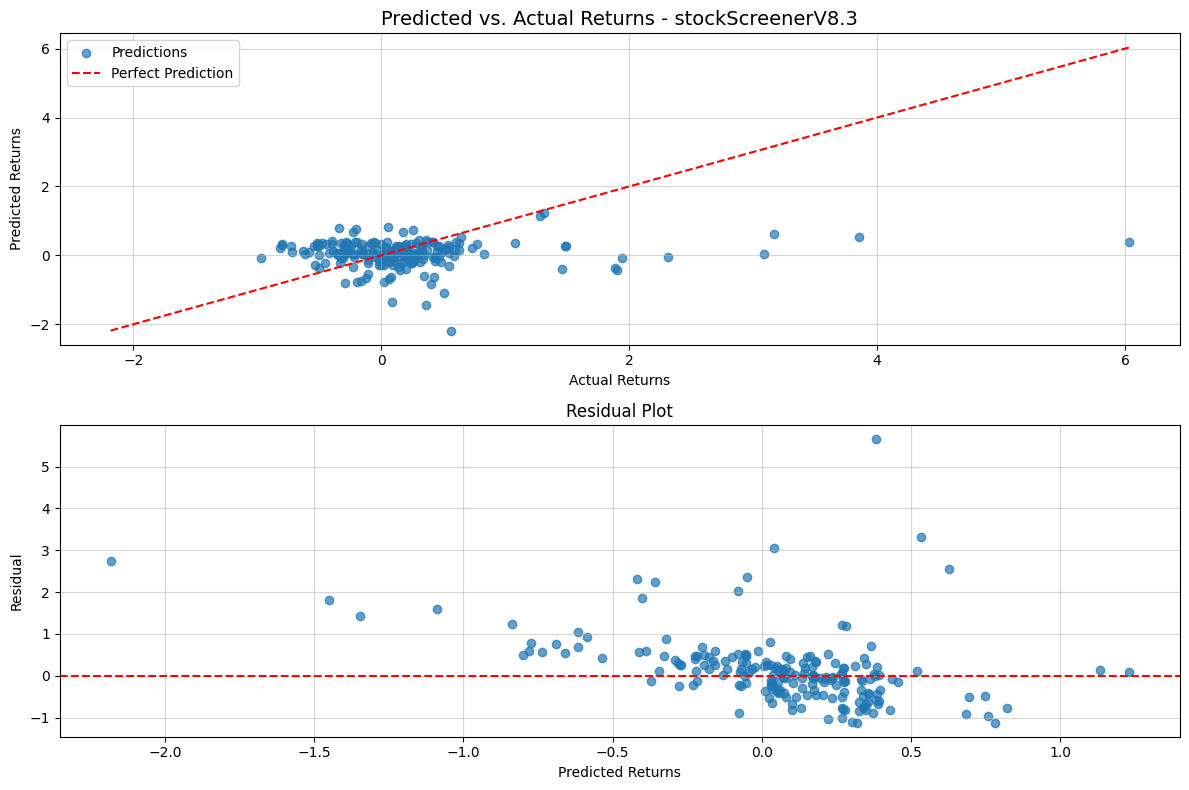

Collected 200 valid test tickers (target: 200)

Evaluation Results:
MAE: 0.527
RMSE: 0.843
R²: -0.243


In [52]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def evaluateModel(learn, test_data, model_name, model_folder, cont_names, cat_names):
    """Evaluate model on pre-collected test data"""
    # Clean data
    test_data_clean = test_data.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(model_name, mae, rmse, r2, model_folder, test_data_clean['Ticker'].unique())
    plotResults(results_df, model_name, model_folder)
    
    return mae, rmse, r2

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Run evaluation
    mae, rmse, r2 = evaluateModel(
        learn=learn,
        test_data=combinedTestData,
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Tests

In [53]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.0.pkl
stockScreenerV2.0.pkl
stockScreenerV3.0.pkl
stockScreenerV4.0.pkl
stockScreenerV4.1.pkl
stockScreenerV5.0.pkl
stockScreenerV5.1.pkl
stockScreenerV5.2.pkl
stockScreenerV5.3.pkl
stockScreenerV5.4.pkl
stockScreenerV6.0.pkl
stockScreenerV8.0.pkl
stockScreenerV8.1.pkl
stockScreenerV8.2.pkl
stockScreenerV8.3.pkl


In [54]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV5.0
Timestamp      2025-01-21 21:03
MAE                       0.237
RMSE                      0.302
R2                       -0.002
Name: 5, dtype: object

### Load model

In [55]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

## Predictions

In [56]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

predictionTarget = '8%'

Prediction for NVO (Novo Nordisk A/S):
51.46%
Free money?!
